In [1020]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")
include("../src/MvGaussHermite.jl")

Main.MvGaussHermite

In [117]:
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt_pstar(x,actions,aux,params)
SigmaN = [0.05;;]

# pstar sigma
Fmin = 0.02
Fmax = 0.2
Bmin = 11.0 # 10% Binf
Bcrit = 44.0  # 40% Binf
Hmax = 200
pstar = 0.4
aux = state -> SurplusProduction.pstar_sigma(pstar,state,(Bmin,Bcrit,Fmin,Fmax),Hmax)

# new observation model 
H = [1.0;;]
function SigmaO(actions,aux)
    Sigma_O = zeros(1,1)
    if actions == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# define model object to compute grid 
actions = [0,1]
model=BeliefStateTransitions.init_model(T,aux,H,actions,SigmaO,SigmaN)  


# Define value function 
Bmax = 150.0
Bmin = 0.1
N = 100
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)


# value function and grid 
grid=BeliefStateTransitions.init_transitions("quadrature",model,V;mQuad = 50)

BeliefStateTransitions.computeTransitions!(grid)


┌ Info:  started timer at: 2022-11-06T09:21:57.783
└ @ TickTock /Users/johnbuckner/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


progress = 5.0%  time: 5.0
progress = 10.0%  time: 5.0
progress = 15.0%  time: 5.0
progress = 20.0%  time: 5.0
progress = 25.0%  time: 6.0
progress = 30.0%  time: 6.0
progress = 35.0%  time: 6.0
progress = 40.0%  time: 6.0
progress = 45.0%  time: 7.0
progress = 50.0%  time: 7.0
progress = 55.0%  time: 7.0
progress = 60.0%  time: 8.0
progress = 65.0%  time: 8.0
progress = 70.0%  time: 8.0
progress = 75.0%  time: 8.0
progress = 80.0%  time: 8.0
progress = 85.0%  time: 8.0
progress = 90.0%  time: 9.0
progress = 95.0%  time: 9.0
progress = 100.0%  time: 9.0


In [140]:
R = (x,actions,aux) -> SurplusProduction.Rpstar(x,actions,aux,10.0,0.0085,1.5) # 
rewards = BeliefStateTransitions.init_rewards(R,model5,V)
BeliefStateTransitions.computeRewards!(rewards)

V = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
print(" ")

MDPsolver.solve_parallel(grid,V,rewards,0.9524)

 interation: 1  convergence: 100000
interation: 2  convergence: 185821.68109243413
interation: 3  convergence: 116680.3650591972
interation: 4  convergence: 92498.13399662779
interation: 5  convergence: 69268.33921156726
interation: 6  convergence: 55793.85804280185
interation: 7  convergence: 50711.435484310576
interation: 8  convergence: 46161.99868681723
interation: 9  convergence: 42283.168939752526
interation: 10  convergence: 39741.879601781795
interation: 11  convergence: 38195.43607436673
interation: 12  convergence: 35237.48447933575
interation: 13  convergence: 32457.343333550627
interation: 14  convergence: 32161.201690875616
interation: 15  convergence: 29977.129740651835
interation: 16  convergence: 29918.38667278357
interation: 17  convergence: 29529.17768143422
interation: 18  convergence: 28093.23700621915
interation: 19  convergence: 26345.901896128238
interation: 20  convergence: 25315.89452466301
interation: 21  convergence: 24662.318163148535
interation: 22  converg

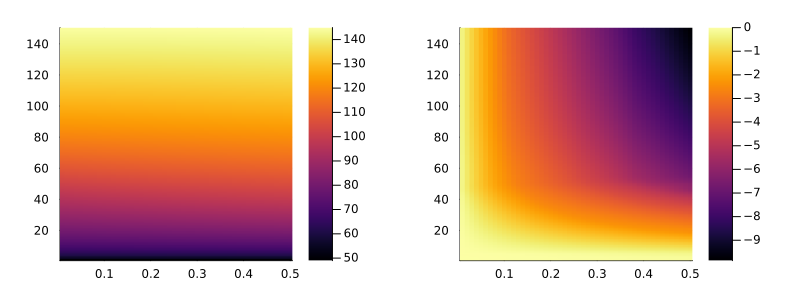

In [141]:
using Plots

function decomp_V(s,V)
    quad = MvGaussHermite.init_mutable(50,[s[1]],[s[2];;])
    vals = broadcast(x->V([x[1],0.0]),quad.nodes)
    Vd = sum(vals.*quad.weights)
    Vs = V(s) - Vd
    return Vd, Vs
end 

function expected_rewards(s,R,aux)
    quad = MvGaussHermite.init_mutable(50,[s[1]],[s[2];;])
    a = aux(s)
    return sum(broadcast(x->R(x,0,a),quad.nodes) .* quad.weights)
end

Bhat = 1.0:1.0:150
sigma = 0.01:0.01:0.5

acc_Vd = zeros(length(Bhat),length(sigma))
acc_Vs = zeros(length(Bhat),length(sigma))
acc_R = zeros(length(Bhat),length(sigma))
i = 0 
for B in Bhat
    i+=1;j=0
    for s in sigma
        j+=1
        acc_Vd[i,j],acc_Vs[i,j]=decomp_V([log(B),s],V)
        acc_R[i,j] = expected_rewards([log(B),s],R,aux)
    end 
end 

p1=Plots.heatmap(sigma,Bhat,acc_Vd)
p2=Plots.heatmap(sigma,Bhat,acc_Vs)
plot(p1,p2,layout=(1,2), size = (800,300),margin=5Plots.mm)

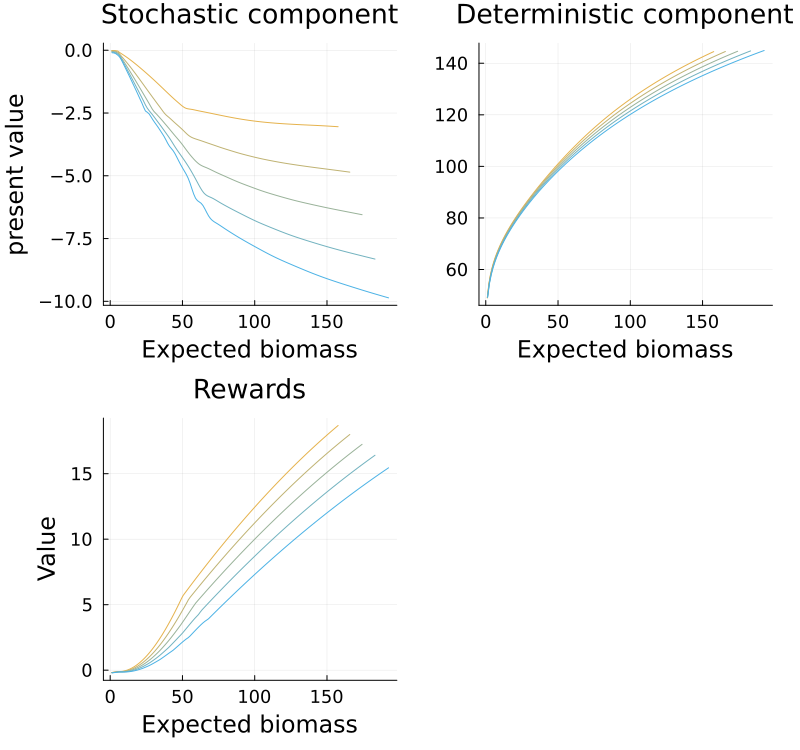

In [142]:


p1=Plots.plot(exp.(log.(Bhat).+0.5*sigma[10]),acc_Vs[:,10],c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[20]),acc_Vs[:,20],c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[30]),acc_Vs[:,30],c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[40]),acc_Vs[:,40],c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[50]),acc_Vs[:,50],c = Colors.RGB(0.3,0.7,0.9),
    legend = false,xlabel = "Expected biomass", ylabel = "present value", title = "Stochastic component",
    guidefontsize=16,tickfontsize=12, titlefontsize=18)

p2=Plots.plot(exp.(log.(Bhat).+0.5*sigma[10]),acc_Vd[:,10],c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[20]),acc_Vd[:,20],c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[30]),acc_Vd[:,30],c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[40]),acc_Vd[:,40],c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[50]),acc_Vd[:,50],c = Colors.RGB(0.3,0.7,0.9),
        legend = false,xlabel = "Expected biomass", title = "Deterministic component",
        guidefontsize=16,tickfontsize=12, titlefontsize=18)

p3=Plots.plot(exp.(log.(Bhat).+0.5*sigma[10]),acc_R[:,10],c = Colors.RGB(0.9,0.7,0.3)) #.+0.5*sigma[10]
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[20]),acc_R[:,20],c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[30]),acc_R[:,30],c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[40]),acc_R[:,40],c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(log.(Bhat).+0.5*sigma[50]),acc_R[:,50],c = Colors.RGB(0.3,0.7,0.9),
        legend = false,xlabel = "Expected biomass", title = "Rewards", ylabel = "Value",
        guidefontsize=16,tickfontsize=12, titlefontsize=18)

plot(p1,p2,p3, size = (800,750),right_margin=5Plots.mm)

In [1039]:
#quad = BeliefStateTransitions.init_QuadQuad(m_x,m_y,xdims,ydims,obs_dims)
#BeliefStateTransitions.integrate!(quadrature::QuadQuad,state,action,model)
function decomp_V_t1(s,a,V,model)
    quad = BeliefStateTransitions.init_QuadQuad(10,10,length(model.mean),size(model.H)[2],size(model.H)[2])
    BeliefStateTransitions.integrate!(quad,s,a,model)
    vals=broadcast(s->decomp_V([s[1][1],s[2][1,1]],V),quad.intermidiate)
    Vd = sum(broadcast(i->vals[i][1], 1:length(quad.intermidiate)) .* quad.weights_y)
    Vs = sum(broadcast(i->vals[i][2], 1:length(quad.intermidiate)) .* quad.weights_y)
    return Vd, Vs
end 


decomp_V_t1 (generic function with 2 methods)

In [1040]:
function decomp_V_pres(s,a,pres_y,V,model,R, delta)
    var_y = 1/pres_y
    var = s[2]
    var_prime = (1/var+1/var_y)^(-1)
    var_mu_prime = var^2/(var+var_y)
    
    quad = MvGaussHermite.init_mutable(15,[s[1]],[var_mu_prime;;])

    vals = broadcast(mu->decomp_V_t1([mu[1],var_prime],a,V,model),quad.nodes)
    
    R_ = broadcast(mu->expected_rewards([mu[1],var_prime],R,model.fixed_control),quad.nodes)
    H_ = broadcast(mu->model.fixed_control([mu[1],var_prime]),quad.nodes)
    
    Vd = sum(broadcast(i->vals[i][1], 1:length(quad.nodes)) .* quad.weights)
    Vs = sum(broadcast(i->vals[i][2], 1:length(quad.nodes)) .* quad.weights)
    R_ = sum(broadcast(i->R_[i], 1:length(quad.nodes)) .* quad.weights)
    return R_, delta*Vd, delta*Vs, sum(H_.* quad.weights)
end



decomp_V_pres (generic function with 1 method)

In [1041]:
function decomp_dVdpres(s,a,V,model,R,delta)
    dx = 1.0
    R_ = expected_rewards(s,R,model.fixed_control)
    H_ = model.fixed_control(s)
    Vd_,Vs_= decomp_V_t1(s,a,V,model)
    R1_,Vd1_,Vs1_,H1_=decomp_V_pres(s,a,dx,V,model,R, delta)
    vals=[(R1_-R_),(Vd1_-delta*Vd_),(Vs1_-delta*Vs_), H1_-H_]#./dx
    return vals
end 

decomp_dVdpres (generic function with 2 methods)

In [1042]:
Bhat = 0.1:1.0:100
sigma = 0.01:0.0075:0.37

acc_Vd = zeros(length(Bhat),length(sigma))
acc_Vs = zeros(length(Bhat),length(sigma))
acc_R = zeros(length(Bhat),length(sigma))
acc_H = zeros(length(Bhat),length(sigma))
i = 0 
for B in Bhat
    print(i)
    i+=1;j=0
    for s in sigma
        j+=1
        vals = decomp_dVdpres([log(B),s],0,V,model,R, delta)
        acc_R[i,j]=vals[1]
        acc_Vd[i,j]=vals[2]
        acc_Vs[i,j]=vals[3]
        acc_H[i,j] = vals[4]
    end 
end 



0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

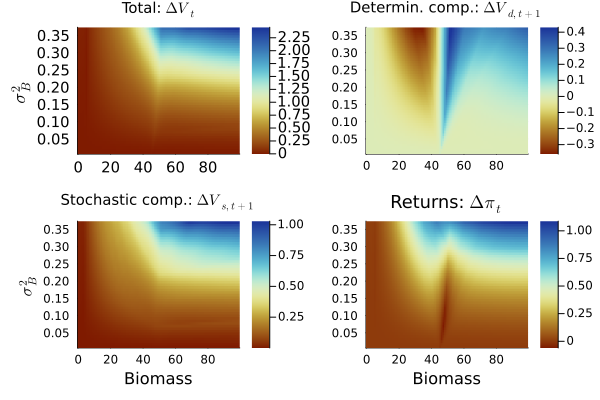

In [1048]:
using LaTeXStrings
lims = (-0.35,3.1)
p1=Plots.heatmap(Bhat,sigma,transpose(acc_Vd),c=:roma,#clim = lims,
title=string("Determin. comp.: ", L"\Delta V_{d,t+1}"),titlefontsize = 10)
#Plots.contour!(sigma,Bhat,acc_Vd,color = "black")
p2=Plots.heatmap(Bhat,sigma,transpose(acc_Vs),c=:roma,#clim = lims,
title=string("Stochastic comp.: ", L"\Delta V_{s,t+1}"),titlefontsize = 10, 
 xlabel = "Biomass", ylabel = L"\sigma_{B}^2")
#Plots.contour!(sigma,Bhat,acc_Vs,color = "black")
p3=Plots.heatmap(Bhat,sigma,transpose(acc_R),c=:roma,#clim = lims, 
title=string("Returns: ", L"\Delta \pi_t"),titlefontsize = 12,xlabel = "Biomass")
#Plots.contour!(sigma,Bhat,acc_R,color = "black")
p4=Plots.heatmap(Bhat,sigma,transpose(acc_R+acc_Vs+acc_Vd), 
title=string("Total: ", L"\Delta V_t"),c=:roma,#clims = lims,
titlefontsize = 10, ylabel = L"\sigma_{B}^2", guidefontsize=12, tickfontsize = 10) 
p5=Plots.heatmap(Bhat,sigma,transpose(acc_H), 
title=string("Harvest: ", L"\Delta H_t"),c=:roma,#clims = lims,
titlefontsize = 10, ylabel = L"\sigma_{B}^2", guidefontsize=12, tickfontsize = 10, xlabel = "Biomass") 
#Plots.contour!(sigma,Bhat,acc_R+acc_Vs+acc_Vd,color = "black")
plot(p4,p1,p2,p3, size = (600,400), bottom_margin = 3Plots.mm, left_margin = 3Plots.mm)


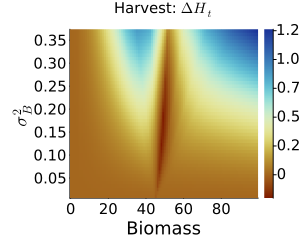

In [1047]:
plot(p5,size = (300,250))

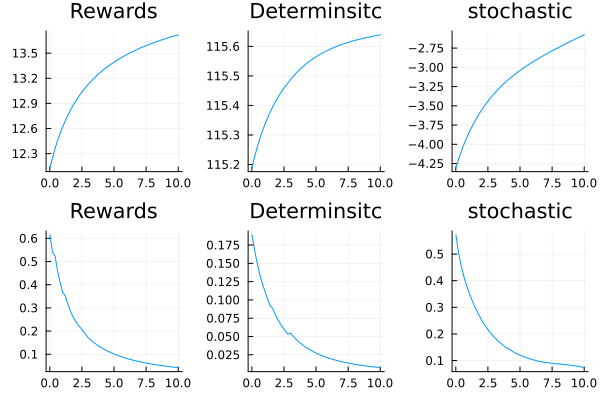

In [705]:
p1=Plots.plot(pres_y_ls,acc_R, title="Rewards",label="")
p2=Plots.plot(pres_y_ls,acc_Vd, title="Determinsitc",label="")
p3=Plots.plot(pres_y_ls,acc_Vs, title="stochastic",label="")
p4=Plots.plot(pres_y_ls,acc_R1, title="Rewards",label="")
p5=Plots.plot(pres_y_ls,acc_Vd1, title="Determinsitc",label="")
p6=Plots.plot(pres_y_ls,acc_Vs1, title="stochastic",label="")
plot(p4,p5,p6,p1,p2,p3)

In [696]:
function decomp_V(s,V,x)
    quad = MvGaussHermite.init_mutable(10,[s[1]],[s[2];;])
    vals = broadcast(x->V([x[1],0.0]),quad.nodes)
    Vd = sum(vals.*quad.weights)
    Vs = V(s) - Vd
    return Vd, Vs, V(s)
end
function decomp_Vt_pres(s,a,pres_y,V)
    var_y = 1/pres_y
    var = s[2]
    var_prime = (1/var+1/var_y)^(-1)
    var_mu_prime = (var_y+var)*(var/(var+var_y))^2
    
    quad = MvGaussHermite.init_mutable(10,[s[1]],[var_mu_prime;;])

    vals = broadcast(mu->decomp_V([mu[1],var_prime],V,1),quad.nodes)

   
    Vd = sum(broadcast(i->vals[i][1], 1:length(quad.nodes)) .* quad.weights)
    Vs = sum(broadcast(i->vals[i][2], 1:length(quad.nodes)) .* quad.weights)
    Vt = sum(broadcast(i->vals[i][3], 1:length(quad.nodes)) .* quad.weights)
    return delta*Vd, delta*Vs, Vt
end

decomp_Vt_pres (generic function with 2 methods)

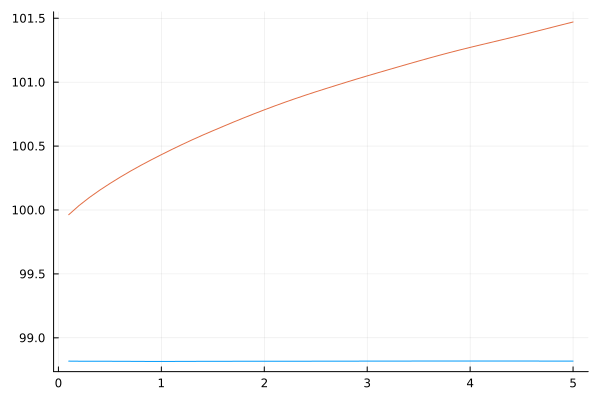

In [697]:
 
Plots.plot(0.1:0.1:5,broadcast(x->decomp_Vt_pres(s,0,x,V)[1],0.1:0.1:5))
#Plots.plot!(0.1:0.1:5,broadcast(x->decomp_Vt_pres(s,0,x,V)[2], 0.1:0.1:5))
Plots.plot!(0.1:0.1:5,broadcast(x->decomp_Vt_pres(s,0,x,V)[3], 0.1:0.1:5),legend = false)

# 